# Векторные репрезентации слов
# Часть 2. Методы понижения размерности частотных матриц
![dim-red](http://www.scinethpc.ca/wp-content/uploads/2012/02/bengio.jpg)  
<center>Picture from [2012 Compute Canada Allocations](https://www.scinethpc.ca/2012-allocations/)</center>
## Оглавление
* Латентно-семантический анализ (LSA)  
* Метод рандомизированныз проекций (Random projections)
* *?Линейный дискриминантный анализ (LDA)*

Необходимые библиотеки

In [1]:
%env MKL_DYNAMIC=FALSE
%env MKL_NUM_THREADS=8

import warnings
warnings.filterwarnings('ignore')

import pickle
import operator
import pandas as pd
import numpy as np
import scipy.sparse as sparse

import gensim
from gensim.models.rpmodel import RpModel
from gensim.models.lsimodel import LsiModel

from nltk.corpus import stopwords
stop = set(stopwords.words('english'))

import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib as mpl
%matplotlib inline

pd.set_option('display.max_columns', None)
pd.set_option('display.mpl_style', 'default')
plt.rc('xtick', labelsize=14) 
plt.rc('ytick', labelsize=14)

from matplotlib import rc
font = {'family': 'Verdana', 'weight': 'normal'}
rc('font', **font)

from pylab import rcParams
rcParams['figure.figsize'] = 15, 5

env: MKL_DYNAMIC=FALSE
env: MKL_NUM_THREADS=8


## Загрузка данных

In [3]:
path_data = '~/'
file = path_data + 'corpora_lem.csv'

arxiv_id = pd.read_csv(path_data + 'corpora_lem.csv', chunksize=1, usecols=['arxiv_id'])
n_corpora = len([_id for _id in arxiv_id])
print("Corpora size: %d" % n_corpora)

Corpora size: 164197


In [4]:
# Сериализация
#
def pickling_data(name, data):
    out = open(name + '.pkl', 'wb')
    pickle.dump(data, out)
    out.close()
    
def load_data(name):
    pkl_file = open(name + '.pkl', 'rb')
    data = pickle.load(pkl_file)
    pkl_file.close()
    return data

In [5]:
# Взвешенные частотные матрицы
#
unigram_matrix_tfidf = load_data('unigram_matrix_tfidf')
print("Рамерность матрицы униграмм: %d x %d" %  unigram_matrix_tfidf.get_shape())
bigram_matrix_tfidf = load_data('bigram_matrix_tfidf')
print("Рамерность матрицы биграмм: %d x %d" %  bigram_matrix_tfidf.get_shape())
trigram_matrix_tfidf = load_data('trigram_matrix_tfidf')
print("Рамерность матрицы триграмм: %d x %d" %  trigram_matrix_tfidf.get_shape())
ngram_matrix_tfidf = sparse.hstack((unigram_matrix_tfidf, bigram_matrix_tfidf, trigram_matrix_tfidf))
print("Рамерность сцепленной матрицы n-грамм: %d x %d" %  ngram_matrix_tfidf.get_shape())
collocation_matrix_tfidf = load_data('collocation_matrix_tfidf')
print("Рамерность матрицы коллокаций: %d x %d" %  collocation_matrix_tfidf.get_shape())

Рамерность матрицы униграмм: 163103 x 54475
Рамерность матрицы биграмм: 163103 x 445023
Рамерность матрицы триграмм: 163103 x 83503
Рамерность сцепленной матрицы n-грамм: 163103 x 583001
Рамерность матрицы коллокаций: 163103 x 97006


### Латентно-семантический анализ
[Описание]  

При **латентно-семантическом анализе (индексировании)** документов задача состоит в том, чтобы спроецировать часто встречающиеся вместе термины в одно и то же измерение семантического пространства, которое имеет пониженную размерность по сравнению с оригинальной терм-документной матрицей, которая обычно довольно разрежена. Элементы этой матрицы содержат веса терминов в документах, назначенные с помощью выбранной весовой функции ($tf-idf$)

Выполняется [сингулярное разложение матрицы](http://www.machinelearning.ru/wiki/index.php?title=SVD). Аппроксимирующая матрица отражает основную структуру зависимостей, содержащихся в исходной матрице.
Каждый термин и документ представляется при помощи векторов в общем семантическом пространстве размерности $k<<n$.

![lsa](https://liqiangguo.files.wordpress.com/2011/06/svd1.jpg?w=640&h=195)

Предположения:
* Документы это просто набор слов, порядок слов в документах игнорируется, важно только то, сколько раз то или иное слово встречается в документе.  
* Семантическое значение документа определяется набором слов, которые как правило идут вместе.   
* Каждое слово имеет единственное значение. 


In [11]:
class LazyCorpora:
    def __init__(self, file, limit=1000):
        self.file = file
        self.limit = limit
    
    def __iter__(self):
        chunks = pd.read_csv(self.file, iterator=True, encoding = "ISO-8859-1")
        for i in range(self.limit):
            row = chunks.read(1)
            content = row['text'].values[0].split()
            cleaned = [token for token in content if token[0] in 'abcdefghijklmnopqrstuvwxyz' and token not in stop]
            condition = len(cleaned) < 15000
            if condition:
                yield cleaned
       
    
documents = LazyCorpora(file)
dictionary = gensim.corpora.Dictionary(documents)
corpus = [dictionary.doc2bow(doc) for doc in documents]

In [12]:
print("Размер словаря: %d" % len(dictionary.token2id))

Размер словаря: 22610


In [13]:
# Обучаем модель
#
n = 50
print("Количество тем: %d" % n)
print("Обучение модели...")
%time lsi = gensim.models.lsimodel.LsiModel(corpus=corpus, id2word=dictionary, num_topics=n)

Количество тем: 50
Обучение модели...
CPU times: user 8.79 s, sys: 640 ms, total: 9.43 s
Wall time: 2.38 s


Элементы диагональной матрицы сингулярного разложения

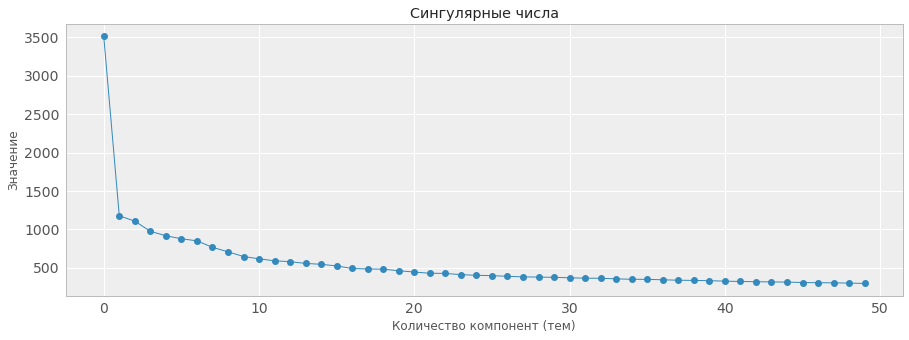

In [14]:
plt.plot(lsi.projection.s, 'o-')
plt.xlabel("Количество компонент (тем)")
plt.ylabel("Значение")
plt.title("Сингулярные числа")
plt.show()

Темы

In [19]:
lsi.print_topic(20, topn=50)

'-0.278*"component" + 0.229*"equation" + 0.216*"sequence" + 0.208*"every" + -0.175*"curve" + -0.171*"orbit" + 0.159*"point" + 0.135*"positive" + -0.134*"vector" + 0.128*"property" + 0.122*"particle" + -0.121*"flow" + 0.116*"cluster" + -0.112*"space" + -0.110*"hyperbolic" + 0.100*"model" + -0.094*"figure" + -0.094*"bifurcation" + -0.092*"proposition" + -0.091*"give" + 0.089*"time" + -0.088*"section" + -0.088*"connect" + 0.087*"critical" + 0.087*"one" + -0.086*"path" + -0.086*"bound" + -0.085*"see" + 0.085*"lemma" + -0.083*"similar" + 0.080*"periodic" + 0.079*"state" + 0.078*"non" + 0.078*"lamination" + 0.077*"integer" + 0.077*"contain" + 0.073*"network" + -0.072*"hence" + 0.072*"exist" + -0.072*"estimate" + -0.071*"type" + -0.071*"field" + -0.070*"parameter" + -0.069*"statement" + -0.066*"self" + -0.065*"function" + 0.065*"leave" + -0.065*"measure" + -0.065*"number" + -0.064*"map"'

**Преобразование**  

Взвешенные частотные матрица трансформируем в плотные матрицы, оставив 1000 наиболее значимых компонент. Полученные модели сохраним на локальный диск.

In [27]:
path_to_models = '/home/kulesh271828/arxiv/models/dim_reduction/' # путь к папке, куда будут сохраняться модели

def create_model(matrix, name, model_type=LsiModel, n=1000):
    '''
    Описание
    '''
    # Трансформируем частотную матрицу в формат корпуса
    #
    corpus = gensim.matutils.Sparse2Corpus(matrix)
    
    # Обучаем модель
    #
    model = model_type(corpus=corpus, id2word=None, num_topics=n)
    
    # Сохранение
    #
    model.save(path_to_models + name)

In [28]:
%%time

create_model(unigram_matrix_tfidf, 'unigram.lsa')
print("Done!")
create_model(bigram_matrix_tfidf, 'bigram.lsa')
print("Done!")
create_model(trigram_matrix_tfidf, 'trigram.lsa')
print("Done!")
create_model(ngram_matrix_tfidf, 'ngram.lsa')
print("Done!")
create_model(collocation_matrix_tfidf, 'collocation.lsa')
print("Done!")

Done!
Done!
Done!
Done!
Done!
CPU times: user 16h 36min 25s, sys: 34min 56s, total: 17h 11min 21s
Wall time: 3h 50min 3s


### Рандомизированные проекции
[Описание]

**Преобразование**

In [29]:
%%time

create_model(unigram_matrix_tfidf, 'unigram.rp', model_type=RpModel)
print("Unigram done!")
create_model(bigram_matrix_tfidf, 'bigram.rp', model_type=RpModel)
print("Bigram done!")
create_model(trigram_matrix_tfidf, 'trigram.rp', model_type=RpModel)
print("Trigram done!")
create_model(ngram_matrix_tfidf, 'ngram.rp', model_type=RpModel)
print("Ngram done!")
create_model(collocation_matrix_tfidf, 'collocation.rp', model_type=RpModel)
print("Collocation done!")

Unigram done!
Bigram done!
Trigram done!
Ngram done!
Collocation done!
CPU times: user 4min 4s, sys: 13.1 s, total: 4min 17s
Wall time: 4min 17s


## Источники

1. Scott Deerwester, Richard Harshman. [Indexing by Latent Semantic Analysis](http://www.cs.bham.ac.uk/~pxt/IDA/lsa_ind.pdf)  
2. models.lsimodel – [Latent Semantic Indexing](http://radimrehurek.com/gensim/models/lsimodel.html)  
- models.rpmodel – [Random Projections](http://radimrehurek.com/gensim/models/rpmodel.html)  
- Колесников Е. В. [SVD-разложение и его практические приложения](https://www.overleaf.com/articles/svd-razlozhieniie-i-iegho-praktichieskiie-prilozhieniia-svd-decomposition-and-its-practical-applications/gkzqbdxdgmry/viewer.pdf)
- @Edunov. [Латентно-семантический анализ](https://habrahabr.ru/post/110078/) -- Habrahabr, 2010.  
- @Surfingbird. [Рекомендательные системы: SVD, часть I](https://habrahabr.ru/company/surfingbird/blog/139863/)  
- @DataNeel. [yelp_lsa.ipynb](https://github.com/DataNeel/yelp_lsa/blob/master/yelp_lsa.ipynb)
- Саламаха О. [Алгоритм LSA для поиска похожих документов](https://netpeak.net/ru/blog/algoritm-lsa-dlya-poiska-pohozhih-dokumentov/)
- Chris McCormick. [Latent Semantic Analysis (LSA) for Text Classification Tutorial](http://mccormickml.com/2016/03/25/lsa-for-text-classification-tutorial/)  
- Linus Sellberg, Arne Jonsson. [Using Random Indexing to improve Singular Value Decomposition for Latent Semantic Analysis](http://www.lrec-conf.org/proceedings/lrec2008/pdf/586_paper.pdf)  
- Ella Bingham and Heikki Mannila. [Random projection in dimensionality reduction: Applications to image and text data](http://users.ics.aalto.fi/ella/publications/randproj_kdd.pdf)
- L. Maaten, E. Postma. [Dimensionality Reduction: A Comparative Review](https://www.tilburguniversity.edu/upload/59afb3b8-21a5-4c78-8eb3-6510597382db_TR2009005.pdf)  